In [1]:
import cv2,os
from skimage import io
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,roc_curve

import torch
from torch.utils.data import Dataset,TensorDataset,random_split,DataLoader,SubsetRandomSampler
from torch.utils.data.dataset import Subset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  1
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# 1. Read data

In [3]:
ls Datasets/CTRL*

Datasets/CTRL_All.npy   Datasets/CTRL_Dapi.npy
Datasets/CTRL_CTCF.npy  Datasets/CTRL_H3K27ac.npy


In [4]:
ls Datasets/RETT*

Datasets/RETT_HPS3042_All.npy      Datasets/RETT_HPS3084_All.npy
Datasets/RETT_HPS3042_CTCF.npy     Datasets/RETT_HPS3084_CTCF.npy
Datasets/RETT_HPS3042_Dapi.npy     Datasets/RETT_HPS3084_Dapi.npy
Datasets/RETT_HPS3042_H3K27ac.npy  Datasets/RETT_HPS3084_H3K27ac.npy
Datasets/RETT_HPS3049_All.npy      Datasets/RETT_HPS9999_All.npy
Datasets/RETT_HPS3049_CTCF.npy     Datasets/RETT_HPS9999_CTCF.npy
Datasets/RETT_HPS3049_Dapi.npy     Datasets/RETT_HPS9999_Dapi.npy
Datasets/RETT_HPS3049_H3K27ac.npy  Datasets/RETT_HPS9999_H3K27ac.npy


In [5]:
stain_type = "H3K27ac"
rett_type  = "HPS3042"

X_Ctrl = np.load(f"./Datasets/CTRL_{stain_type}.npy",allow_pickle=True)
X_Rett = np.load(f"./Datasets/RETT_{rett_type}_{stain_type}.npy",allow_pickle=True)
y_Ctrl = torch.zeros(len(X_Ctrl), dtype=torch.int64)
y_Rett = torch.ones(len(X_Rett), dtype=torch.int64)
X = np.concatenate((X_Ctrl, X_Rett), axis = 0)
y = torch.cat((y_Ctrl, y_Rett), 0)

# 2. Data processing

In [6]:
class cell_dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.transform(self.x[idx]).to(torch.float), F.one_hot(self.y[idx],num_classes=2).to(torch.float)

dataset = cell_dataset(X, y)

In [7]:
batch_size = 64
train_size = int(len(X)*0.8)
valid_size = len(X) - train_size

train_data, valid_data = random_split(dataset=dataset, lengths=[train_size, valid_size], 
                                      generator=torch.Generator().manual_seed(42))
dataloader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

# 3. ResNet model

In [8]:
# model_type="Resnet10_noavg"
# rett_type_test = "HPS3042"
# homepath="/groups/4/gaa50089/acd13264yb/Rettsyndrome/Classification"
# modelpath=f"{homepath}/results/{rett_type_test}_{stain_type}_{model_type}/{rett_type_test}_{stain_type}_{model_type}_Fold0.pkl"
# weight = torch.load(modelpath)
# print(modelpath)

# UNet model

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)
    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
#         self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)
    def forward(self, down_input, skip_input):
        skip_shape = skip_input.shape
        x = F.interpolate(down_input, size=[skip_shape[2],skip_shape[3]],mode='nearest-exact')
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512)
        self.up_conv3 = UpBlock(256 + 512, 256)
        self.up_conv2 = UpBlock(128 + 256, 128)
        self.up_conv1 = UpBlock(64 + 128, 64)
        # output
        self.output = nn.Conv2d(64,1,kernel_size=1)
#         self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_image):
        x, skip1_out = self.down_conv1(input_image)
        print(f"x.size {x.size()} skip1_out.size {skip1_out.size()}")
        x, skip2_out = self.down_conv2(x)
        print(f"x.size {x.size()} skip1_out.size {skip1_out.size()}")
        x, skip3_out = self.down_conv3(x)
        print(f"x.size {x.size()} skip1_out.size {skip1_out.size()}")
        x, skip4_out = self.down_conv4(x)
        print(f"x.size {x.size()} skip1_out.size {skip1_out.size()}")
        x = self.double_conv(x)
        print(f"x.size {x.size()}")
        x = self.up_conv4(x, skip4_out)
        print(f"x.size {x.size()} skip1_out.size {skip1_out.size()}")
        x = self.up_conv3(x, skip3_out)
        print(f"x.size {x.size()} skip1_out.size {skip1_out.size()}")
        x = self.up_conv2(x, skip2_out)
        print(f"x.size {x.size()} skip1_out.size {skip1_out.size()}")
        x = self.up_conv1(x, skip1_out)
        print(f"x.size {x.size()} skip1_out.size {skip1_out.size()}")
        x = self.output(x)
        print(f"x.size {x.size()}")
#         x = self.sigmoid(x)
        return x

In [11]:
class maskUNet(nn.Module):
    def __init__(self):
        super(maskUNet, self).__init__()
        self.UNetblock = UNet()  # 确保 UNet 已经定义
        self.fc = nn.Linear(500 * 500, 2)  # 假设UNet输出大小是500x500，全连接层输出为两个类别

    def forward(self, input_image):
        # UNet 处理
        mask = self.UNetblock(input_image)
        
        # 展平操作
        output = torch.flatten(mask, start_dim=1)  # 保持batch维度不变，展平其他维度
        
        # 全连接层
        output = self.fc(output)

        return mask, output

In [12]:
model = maskUNet().to(device)
# model = nn.DataParallel(model, list(range(ngpu)))

x.size torch.Size([1, 64, 250, 250]) skip1_out.size torch.Size([1, 64, 500, 500])
x.size torch.Size([1, 128, 125, 125]) skip1_out.size torch.Size([1, 64, 500, 500])
x.size torch.Size([1, 256, 62, 62]) skip1_out.size torch.Size([1, 64, 500, 500])
x.size torch.Size([1, 512, 31, 31]) skip1_out.size torch.Size([1, 64, 500, 500])
x.size torch.Size([1, 1024, 31, 31])
x.size torch.Size([1, 512, 62, 62]) skip1_out.size torch.Size([1, 64, 500, 500])
x.size torch.Size([1, 256, 125, 125]) skip1_out.size torch.Size([1, 64, 500, 500])
x.size torch.Size([1, 128, 250, 250]) skip1_out.size torch.Size([1, 64, 500, 500])
x.size torch.Size([1, 64, 500, 500]) skip1_out.size torch.Size([1, 64, 500, 500])
x.size torch.Size([1, 1, 500, 500])
torch.Size([1, 2])
torch.Size([1, 1, 500, 500])


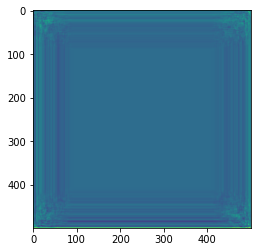

In [13]:
image_size = 500
test_input = torch.ones(1,3,image_size,image_size).to(device)
mask, output = model(test_input)
print(output.size())
print(mask.size())
plt.imshow(mask[0,0,:,:].cpu().detach().numpy())
# print(nn.Softmax(dim=1)(output))
# print(output.argmax(1))

# 4. Train

In [14]:
model.avgpool = nn.AdaptiveAvgPool2d(1)

# loss_function = nn.BCELoss()
weights = torch.tensor([(len(X_Ctrl)+len(X_Rett))/len(X_Ctrl), 
                        (len(X_Ctrl)+len(X_Rett))/len(X_Rett)]).cuda()
# loss_function = nn.CrossEntropyLoss(weight=weights)
loss_function = nn.BCEWithLogitsLoss(pos_weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

def train(model,device,dataloader_train,loss_function,optimizer):
    losses_train = []
    n_train = 0
    acc_train = 0
    optimizer.step()
    model.train()
    for x, y in dataloader_train:
        n_train += y.size()[0]
        model.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        acc_train += (output.argmax(1) == y[:,1]).float().sum().item()
        losses_train.append(loss.tolist())
    return np.mean(losses_train), (acc_train/n_train)
        
def valid(model,device,dataloader_valid,loss_function):
    losses_valid = []
    n_val = 0
    acc_val = 0
    model.eval()
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        acc_val += (output.argmax(1) == y[:,1]).float().sum().item()
        losses_valid.append(loss.tolist())
    return np.mean(losses_valid), (acc_val/n_val)

history = {'loss_train': [], 'loss_valid': [],'acc_train':[],'acc_valid':[]}

In [15]:
n_epochs = 10
for epoch in range(n_epochs):
    loss_train, acc_train = train(model,device,dataloader_train,loss_function,optimizer)
    loss_valid, acc_valid = valid(model,device,dataloader_valid,loss_function)
    scheduler.step()
    
    history['loss_train'].append(loss_train)
    history['loss_valid'].append(loss_valid)
    history['acc_train'].append(acc_train)
    history['acc_valid'].append(acc_valid)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'
          .format(epoch, loss_train, acc_train, loss_valid, acc_valid))

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.82 GiB (GPU 0; 15.77 GiB total capacity; 13.10 GiB already allocated; 1.38 GiB free; 13.25 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

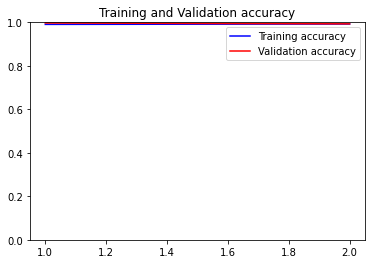

<Figure size 432x288 with 0 Axes>

In [32]:
# train processing plot
n_epochs = 50
epochs=range(1,n_epochs+1)
plt.ylim(0,1.0)
plt.plot(epochs, history['acc_train'], 'b', label='Training accuracy')  
plt.plot(epochs, history['acc_valid'], 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

# 4. Validate data

In [55]:
def plot_and_save_roc_curve(y_true, y_scores, fold):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)
    return auc_score

def valid(model, device, dataloader_valid):
    model.eval()
    y_true = []
    y_scores = []
    acc_val = 0
    n_val = 0
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            output = model(x)
        y_true.extend(y[:,1].tolist())  # 假设y的第二列是标签
        y_scores.extend(output[:,1].sigmoid().tolist())  # 假设模型的第二个输出是预测为正类的得分
        acc_val += (output.argmax(1) == y[:,1]).float().sum().item()
    auc_score = plot_and_save_roc_curve(y_true, y_scores, fold)  # 调用ROC绘图函数
    return acc_val / n_val, auc_score

def loaddata(stain_type, rett_type):
    X_Ctrl = np.load(f"{homepath}/Datasets/CTRL_{stain_type}.npy",allow_pickle=True)
    X_Rett = np.load(f"{homepath}/Datasets/RETT_{rett_type}_{stain_type}.npy",allow_pickle=True)
    y_Ctrl = torch.zeros(len(X_Ctrl), dtype=torch.int64)
    y_Rett = torch.ones(len(X_Rett), dtype=torch.int64)
    X = np.concatenate((X_Ctrl, X_Rett), axis = 0)
    y = torch.cat((y_Ctrl, y_Rett), 0)
    dataset = cell_dataset(X, y)
    return dataset

In [56]:
# whole data
# stain_type = "H3K27ac"
# rett_type  = "HPS3042"
# rett_type_model = "HPS3042"
model_type="Resnet10_noavg"
homepath="/groups/4/gaa50089/acd13264yb/Rettsyndrome/Classification"

stain_list = ["All", "H3K27ac", "CTCF", "Dapi"]
rett_list = ["HPS3042", "HPS3049", "HPS3084"]
for stain_type in stain_list:
    print(f"{stain_type}")

    for rett_type in rett_list:
        for rett_type_model in rett_list:
            dataset = loaddata(stain_type, rett_type)

            history = {'acc_valid':[], 'auc_valid':[]}
            print(f"Data {rett_type}, Model {rett_type_model}", end='  ')

            dataloader_valid = DataLoader(dataset, batch_size=batch_size)

            modelpath=f"{homepath}/results/{rett_type_model}_{stain_type}_{model_type}/{rett_type_model}_{stain_type}_{model_type}_Fold0.pkl"
            weight = torch.load(modelpath)

            model = ResNet().to(device)
            model.avgpool = nn.AdaptiveAvgPool2d(1)

            acc_valid, auc_valid = valid(model, device, dataloader_valid)
            print(f'Accuracy: {acc_valid:.3f}, AUC: {auc_valid:.3f}')
            history['acc_valid'].append(acc_valid)
            history['auc_valid'].append(auc_valid)

All
🔶 Data HPS3042, 🔷 Model HPS3042  Accuracy: 0.994, AUC: 1.000

🔶 Data HPS3042, 🔷 Model HPS3049  Accuracy: 0.748, AUC: 0.888

🔶 Data HPS3042, 🔷 Model HPS3084  Accuracy: 0.911, AUC: 0.990

🔶 Data HPS3049, 🔷 Model HPS3042  Accuracy: 0.599, AUC: 0.833

🔶 Data HPS3049, 🔷 Model HPS3049  Accuracy: 0.985, AUC: 0.999

🔶 Data HPS3049, 🔷 Model HPS3084  Accuracy: 0.624, AUC: 0.871

🔶 Data HPS3084, 🔷 Model HPS3042  Accuracy: 0.988, AUC: 1.000

🔶 Data HPS3084, 🔷 Model HPS3049  Accuracy: 0.798, AUC: 0.960

🔶 Data HPS3084, 🔷 Model HPS3084  Accuracy: 0.999, AUC: 1.000

H3K27ac
🔶 Data HPS3042, 🔷 Model HPS3042  Accuracy: 0.981, AUC: 0.999

🔶 Data HPS3042, 🔷 Model HPS3049  Accuracy: 0.657, AUC: 0.481

🔶 Data HPS3042, 🔷 Model HPS3084  Accuracy: 0.929, AUC: 0.985

🔶 Data HPS3049, 🔷 Model HPS3042  Accuracy: 0.565, AUC: 0.477

🔶 Data HPS3049, 🔷 Model HPS3049  Accuracy: 0.953, AUC: 0.992

🔶 Data HPS3049, 🔷 Model HPS3084  Accuracy: 0.559, AUC: 0.501

🔶 Data HPS3084, 🔷 Model HPS3042  Accuracy: 0.894, AUC: 0.9

In [58]:
# 5-Fold
stain_type = "H3K27ac"
rett_type  = "HPS3042"
model_type="Resnet10_noavg"
rett_type_model = "HPS3042"
homepath="/groups/4/gaa50089/acd13264yb/Rettsyndrome/Classification"

stain_list = ["All", "H3K27ac", "CTCF", "Dapi"]
rett_list = ["HPS3042", "HPS3049", "HPS3084"]
for stain_type in stain_list:
    print(f"{stain_type}")

    for rett_type in rett_list:
        for rett_type_model in rett_list:
            dataset = loaddata(stain_type, rett_type)

            n_splits=5
            splits=KFold(n_splits,shuffle=True,random_state=42)
            history = {'acc_valid':[], 'auc_valid':[]}
            for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
                if fold != 0: break
                print(f"Data {rett_type}, Model {rett_type_model}_Fold{fold}", end='  ')
                valid_sampler = SubsetRandomSampler(val_idx)
                dataloader_valid = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

                modelpath=f"{homepath}/results/{rett_type_model}_{stain_type}_{model_type}/{rett_type_model}_{stain_type}_{model_type}_Fold{fold}.pkl"
                weight = torch.load(modelpath)

                model = ResNet().to(device)
                model.avgpool = nn.AdaptiveAvgPool2d(1)

                acc_valid, auc_valid = valid(model, device, dataloader_valid)
                print(f'Accuracy: {acc_valid:.3f}, AUC: {auc_valid:.3f}')
                history['acc_valid'].append(acc_valid)
                history['auc_valid'].append(auc_valid)

All
Data HPS3042, Model HPS3042_Fold0  Accuracy: 0.971, AUC: 0.998
Data HPS3042, Model HPS3049_Fold0  Accuracy: 0.726, AUC: 0.848
Data HPS3042, Model HPS3084_Fold0  Accuracy: 0.914, AUC: 0.987
Data HPS3049, Model HPS3042_Fold0  Accuracy: 0.611, AUC: 0.812
Data HPS3049, Model HPS3049_Fold0  Accuracy: 0.925, AUC: 0.977
Data HPS3049, Model HPS3084_Fold0  Accuracy: 0.645, AUC: 0.855
Data HPS3084, Model HPS3042_Fold0  Accuracy: 0.985, AUC: 0.999
Data HPS3084, Model HPS3049_Fold0  Accuracy: 0.810, AUC: 0.927
Data HPS3084, Model HPS3084_Fold0  Accuracy: 0.993, AUC: 1.000
H3K27ac
Data HPS3042, Model HPS3042_Fold0  Accuracy: 0.907, AUC: 0.975
Data HPS3042, Model HPS3049_Fold0  Accuracy: 0.622, AUC: 0.434
Data HPS3042, Model HPS3084_Fold0  Accuracy: 0.905, AUC: 0.967
Data HPS3049, Model HPS3042_Fold0  Accuracy: 0.575, AUC: 0.405
Data HPS3049, Model HPS3049_Fold0  Accuracy: 0.765, AUC: 0.858
Data HPS3049, Model HPS3084_Fold0  Accuracy: 0.548, AUC: 0.366
Data HPS3084, Model HPS3042_Fold0  Accuracy

# 99. Save model

In [24]:
for param in model.parameters():
    param.requires_grad = True
torch.save(model.module.resnet.state_dict(),"Models/Resnet_H3K27ac.pkl")

In [81]:
class ResNet(nn.Module):
        def __init__(self):
            super(ResNet,self).__init__()
            self.resnet = models.resnet18(weights=True)
            self.resnet.layer3 = nn.Sequential()
            self.resnet.layer4 = nn.Sequential()
            self.resnet.avgpool = nn.Sequential()
            self.resnet.fc = nn.Linear(128*75*75, 2)
            self.resnet.load_state_dict(weight)
        def forward(self, x):
            x = self.resnet(x)
            x = nn.Softmax(dim=1)(x)
            return x
model = ResNet()